In [1]:
import numpy as np
import pandas as pd
import skimage as ski
import skimage.io as skio
import os
import cv2
import scipy 
from scipy.signal import convolve, convolve2d, unit_impulse
import scipy.fft as fft
import matplotlib.pyplot as plt
import tifffile
import imageio
from align_image_code import align_images

In [2]:
def process_img(img_name):
    return skio.imread(f"data/{img_name}")

def process_img_gray(img_name):
    im = skio.imread(f"data/{img_name}")
    return im.dot([0.2989, 0.5870, 0.1140]) / 255.

def magnitude(dx, dy):
    return np.sqrt(dx**2 + dy**2)

def gradient_magnitude(img, threshold = 50):
    dx, dy = np.array([[1, -1]]), np.array([[1], [-1]])
    hor_diff = convolve2d(img, dx, mode='same')
    ver_diff = convolve2d(img, dy, mode='same')
    mag = magnitude(hor_diff, ver_diff)
    mag_bin = np.where(mag > threshold, 0, 1)
    plt.imshow(mag_bin, cmap = 'Greys')
    plt.title('Gradient Magnitude') 
    return mag_bin

def summary_stats(arr):
    print(pd.DataFrame(arr.flatten()).describe())

def rescale_255(img):
    img = (img - np.min(img))
    img = img / np.max(img) * 255
    return img.astype(int)

def rgb2gray(rgb):
    # Based on luminance perception of human vision. This is usually what is going on under the hood.
    return rgb.dot([0.2989, 0.5870, 0.1140])

def get_dx_op():
    dx_op = np.tile(np.array([-1, 0, 1])[None,:], [3, 1]) / 2
    return dx_op

def get_dy_op():
    dy_op = np.tile(np.array([-1, 0, 1])[:, None], [1, 3]) / 2
    return dy_op

def plot_images(images, titles=None, max_width=15, max_height=10, vertical=False):
    n = len(images)
    height, width = images[0].shape[:2]
    aspect_ratio = width / height
    
    if vertical:
        fig_height = min(max_height, n * 5)
        fig_width = fig_height * aspect_ratio / n
        if fig_width > max_width:
            fig_width = max_width
            fig_height = fig_width * n / aspect_ratio
        nrows, ncols = n, 1
    else:
        fig_width = min(max_width, n * 5)
        fig_height = fig_width / (n * aspect_ratio)
        if fig_height > max_height:
            fig_height = max_height
            fig_width = fig_height * (n * aspect_ratio)
        nrows, ncols = 1, n
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(fig_width, fig_height))
    
    if n == 1:
        axes = [axes]
    
    for i, (img, ax) in enumerate(zip(images, axes.ravel())):
        if img.ndim == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(img)
        
        if titles and i < len(titles):
            ax.set_title(titles[i])
        
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    return fig

## Part 1.1

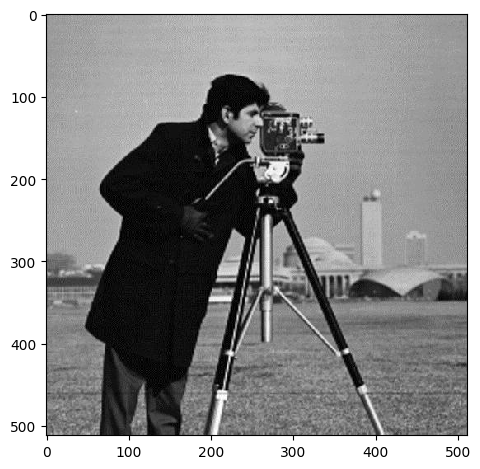

In [3]:
cameraman = process_img('cameraman.jpg')[:,:,0]
skio.imshow(cameraman)

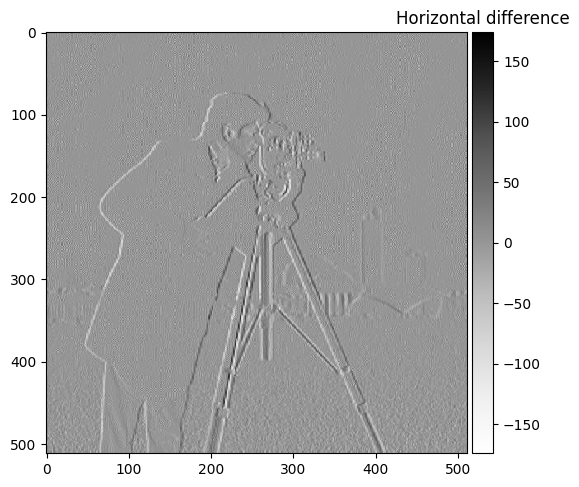

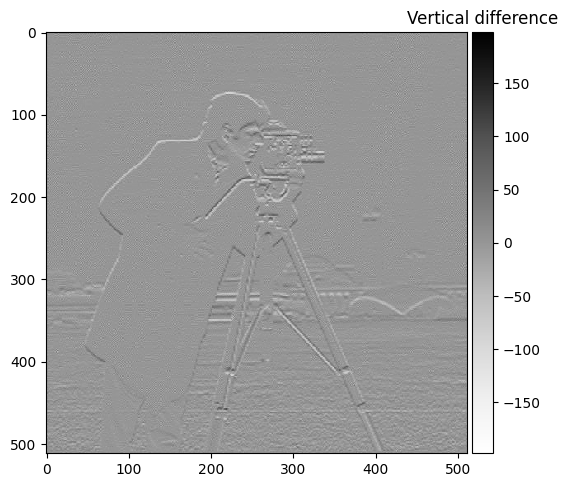

Text(0.5, 1.0, 'Gradient Magnitude')

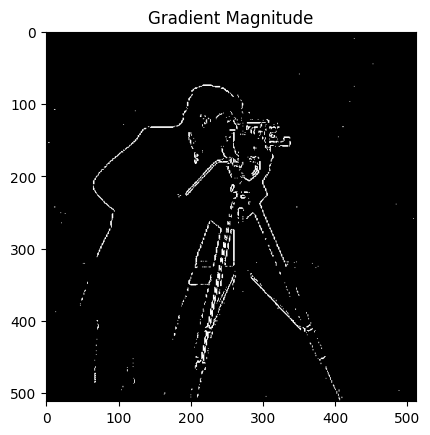

In [4]:
threshold = 0
dx, dy = np.array([[1, -1]]), np.array([[1], [-1]])
hor_diff = convolve2d(cameraman, dx, mode='same')
ver_diff = convolve2d(cameraman, dy, mode='same')

threshold = 60
mag = magnitude(hor_diff, ver_diff)
mag_bin = np.where(mag > threshold, 0, 1)
skio.imshow(hor_diff, cmap = 'Greys')
plt.title('Horizontal difference')
plt.show()
skio.imshow(ver_diff, cmap = 'Greys')
plt.title('Vertical difference')
plt.show()
plt.imshow(mag_bin, cmap = 'Greys')
plt.title('Gradient Magnitude')

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       ...,
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1],
       [0, 1, 1, ..., 1, 1, 1]])

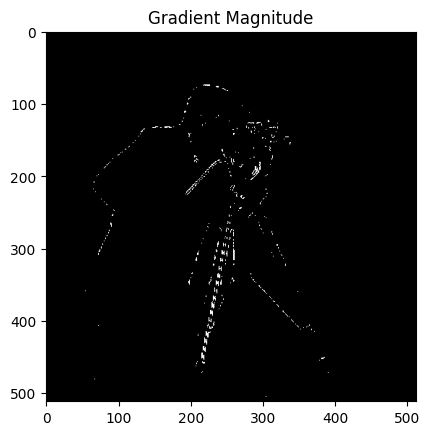

In [5]:
gradient_magnitude(cameraman, threshold=80)

## Part 1.2

Text(0.5, 1.0, 'Gradient Magnitude')

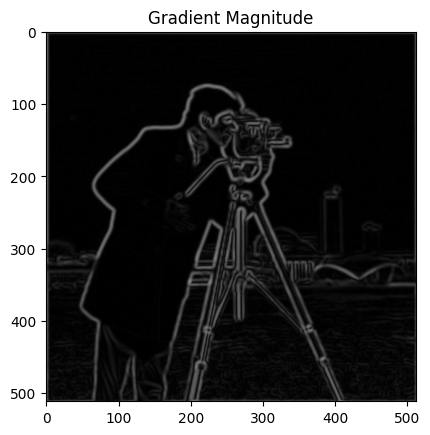

In [6]:
# (img * gauss) * dx or dy
k_size, sigma = 10, 2
gauss_2d = cv2.getGaussianKernel(k_size, sigma) @ cv2.getGaussianKernel(k_size, sigma).T
img_gauss = convolve2d(cameraman, gauss_2d, mode='same')
hor_diff = convolve2d(img_gauss, dx, mode='same')
ver_diff = convolve2d(img_gauss, dy, mode='same')
plt.imshow(-magnitude(hor_diff, ver_diff), cmap = 'Greys')
plt.title('Gradient Magnitude')

Text(0.5, 1.0, 'Gradient Magnitude')

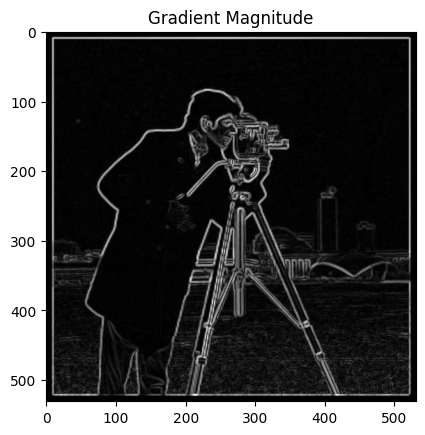

In [7]:
# img * (gauss * dx or dy)
k_size, sigma = 20, 1
gauss_2d = cv2.getGaussianKernel(k_size, sigma) @ cv2.getGaussianKernel(k_size, sigma).T
gauss_dx = convolve2d(gauss_2d, dx, mode='same')
gauss_dy = convolve2d(gauss_2d, dy, mode='same')
hor_diff = convolve2d(cameraman, gauss_dx)
ver_diff = convolve2d(cameraman, gauss_dy)
plt.imshow(-magnitude(hor_diff, ver_diff), cmap = 'Greys')
plt.title('Gradient Magnitude')

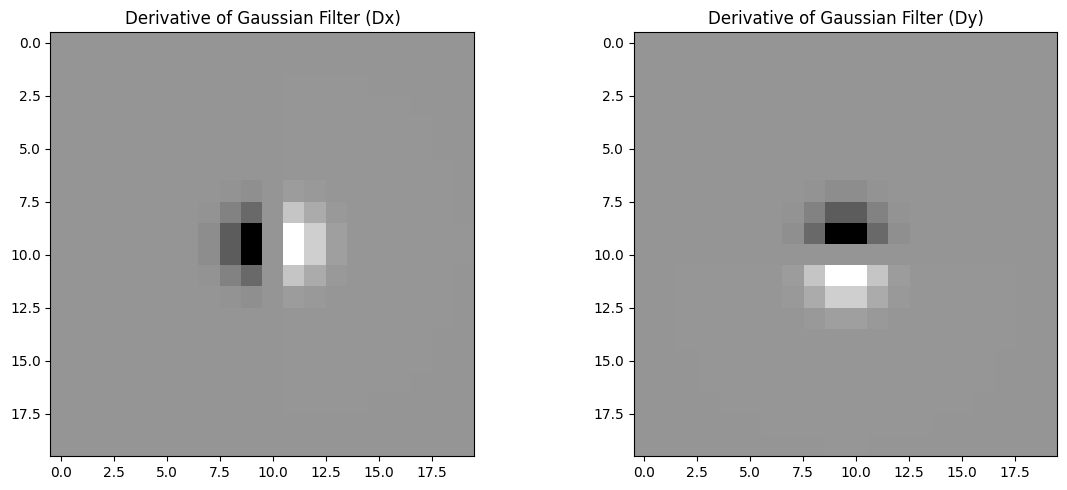

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
im1 = ax1.imshow(gauss_dx, cmap='Greys')
ax1.set_title('Derivative of Gaussian Filter (Dx)')
im2 = ax2.imshow(gauss_dy, cmap='Greys')
ax2.set_title('Derivative of Gaussian Filter (Dy)')
plt.tight_layout()
plt.show()

## Part 2.1

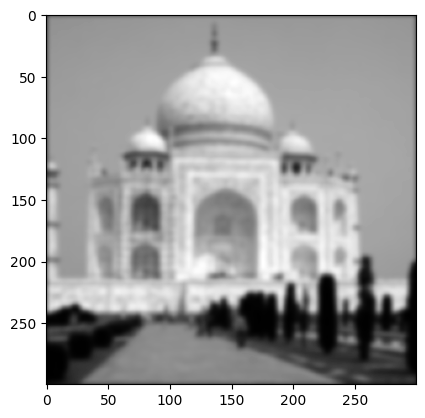

In [9]:
taj = process_img('taj.jpg')
taj_gray = rgb2gray(taj) / 255.
plt.imshow(taj_gray, cmap="gray")
k_size, sigma = 10, 2
gauss_2d = cv2.getGaussianKernel(k_size, sigma) @ cv2.getGaussianKernel(k_size, sigma).T
taj_blur = convolve2d(taj_gray, gauss_2d, mode='same')
plt.imshow(taj_blur, cmap='grey')

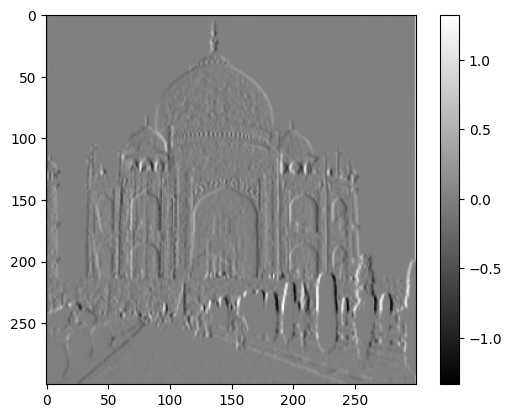

In [10]:
dx_op = get_dx_op()
taj_blur_dx = convolve2d(taj_gray, dx_op, mode="same");
plt.imshow(taj_blur_dx, cmap="gray"); plt.colorbar();

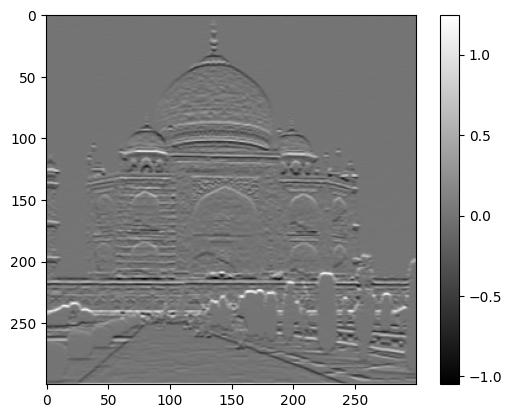

In [11]:
dy_op = get_dy_op()
taj_blur_dy = convolve2d(taj_gray, dy_op, mode="same");
plt.imshow(taj_blur_dy, cmap="gray"); plt.colorbar();

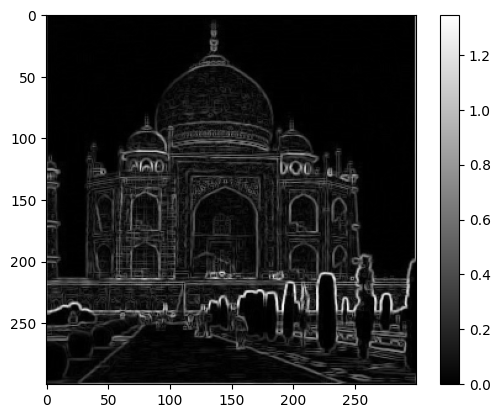

In [12]:
dy_op = get_dy_op()
taj_grad = magnitude(taj_blur_dx, taj_blur_dy)# > 0.4, 1, 0)
plt.imshow(taj_grad, cmap="gray"); plt.colorbar();

                  0
count  9.000000e+04
mean  -1.136868e-17
std    1.000006e+00
min   -7.954787e+00
25%   -2.116191e-01
50%   -5.640122e-02
75%    2.276741e-01
max    7.130363e+00
None


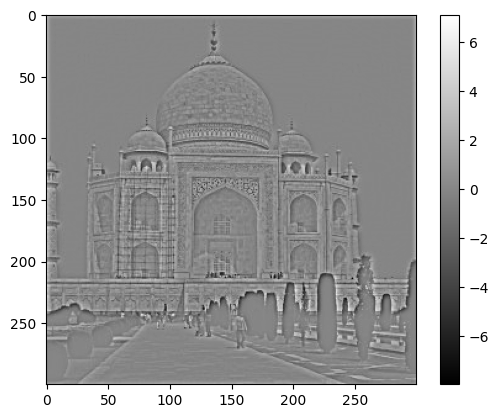

In [13]:
taj_edges = taj_gray - taj_blur
taj_edges = (taj_edges - np.mean(taj_edges))/np.std(taj_edges)
print(summary_stats(taj_edges))
plt.imshow(taj_edges, cmap="gray"); plt.colorbar();

                   0
count  270000.000000
mean      141.142585
std        67.962356
min         0.000000
25%       114.000000
50%       148.000000
75%       194.000000
max       255.000000
None


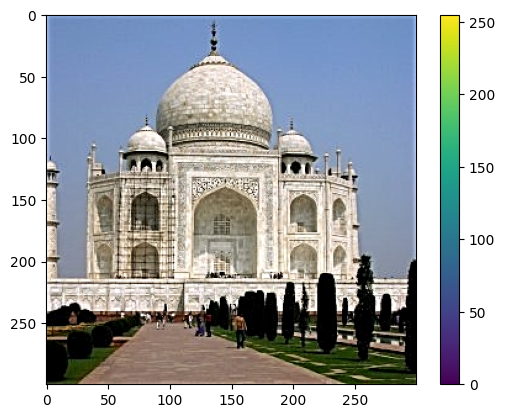

In [14]:
alpha = 20
taj_sharp = np.clip(taj+alpha*np.dstack([taj_edges]*3), 0., 255.).astype(int)
print(summary_stats(taj_sharp))
plt.imshow(taj_sharp); plt.colorbar();

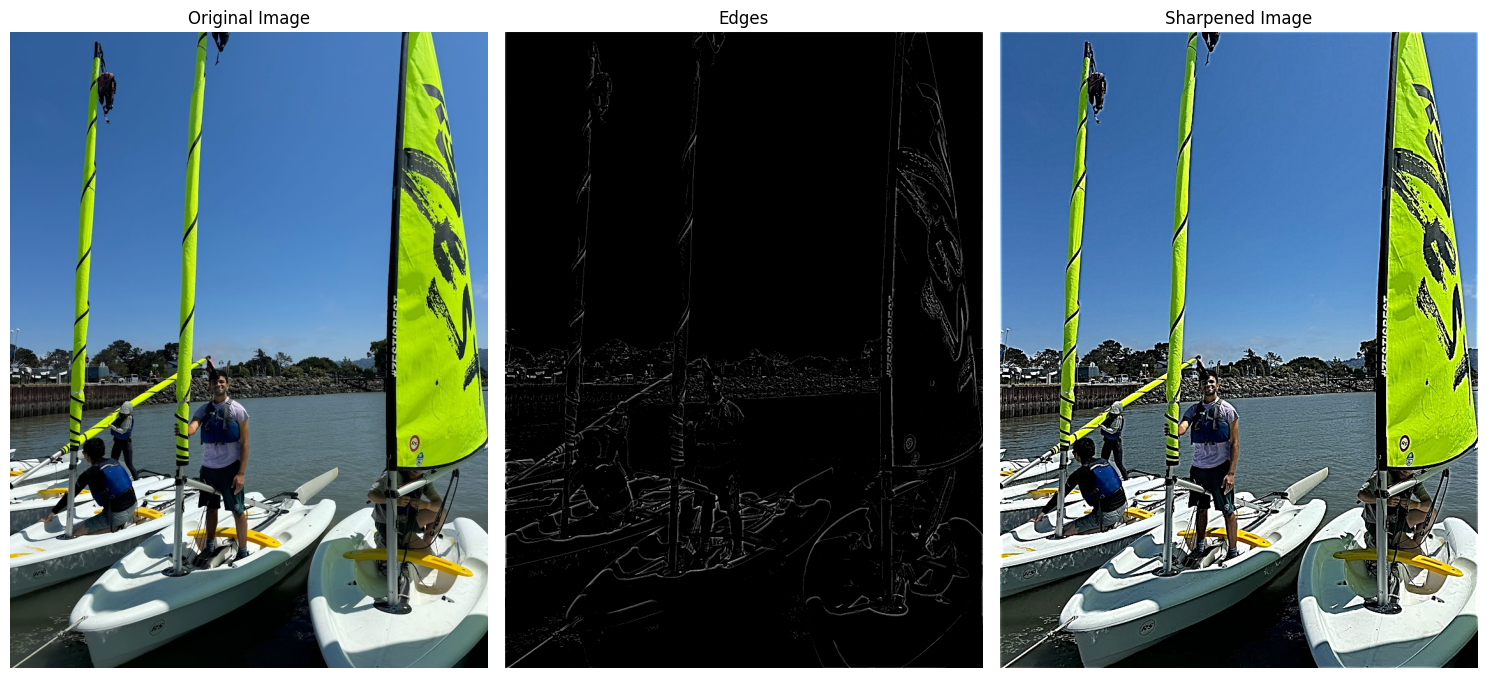

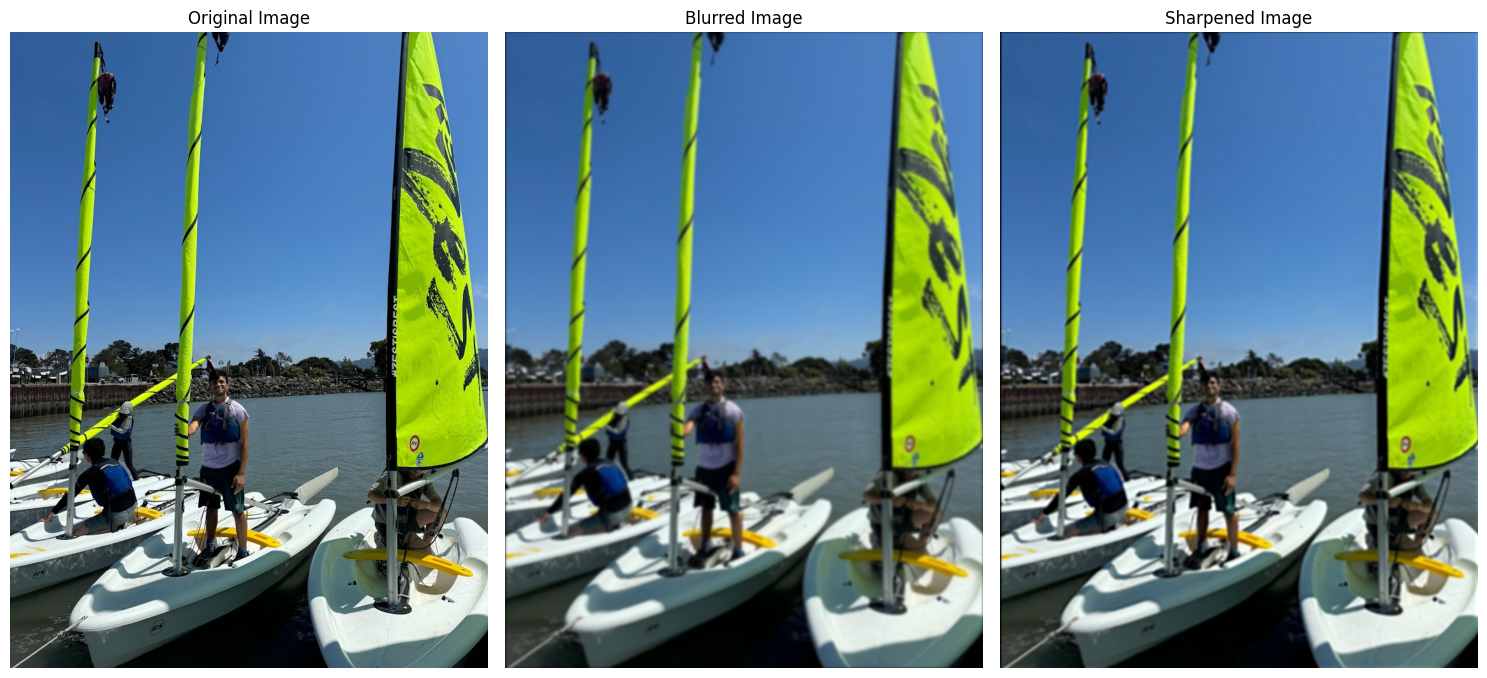

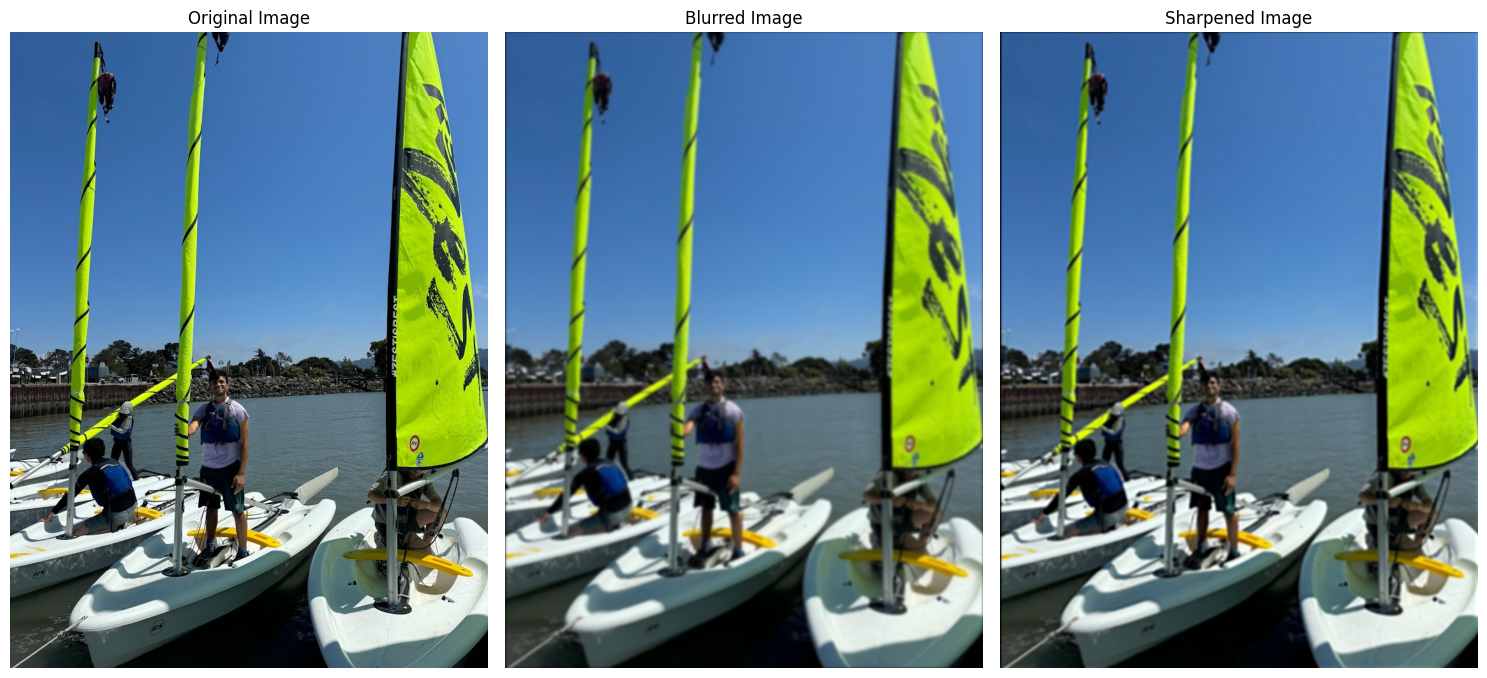

In [15]:
def blur3d(img, k_size = 10, sigma = 2):
    return np.dstack([blur(img[:,:,i], k_size = k_size, sigma=sigma) for i in range(img.shape[2])]).astype(int)

def blur(img, k_size = 10, sigma = 2):
    gauss_2d = cv2.getGaussianKernel(k_size, sigma) @ cv2.getGaussianKernel(k_size, sigma).T
    img_blur = convolve2d(img, gauss_2d, mode='same')
    return img_blur

def sharpen(img, alpha = 10):
    if type(img) == str:
        img = process_img(img)
    
    img_gray = rgb2gray(img)
    img_blur = blur(img_gray)
    img_edges = img_gray - img_blur
    img_sharp = np.clip(img+alpha*np.dstack([img_edges]*3), 0., 255.).astype(int)
    return img, img_edges, img_sharp

def sharpen_filter(img, alpha = 10):
    if type(img) == str:
        img = process_img(img)
    e = unit_impulse((k_size, k_size), idx = 'mid')
    gauss_2d = cv2.getGaussianKernel(k_size, sigma) @ cv2.getGaussianKernel(k_size, sigma).T
    img_sharp = np.dstack([convolve2d(img[:,:,i], (1+alpha)*e - alpha*gauss_2d, mode='same') for i in range(img.shape[2])])
    img_sharp = np.clip(img_sharp, 0., 255.).astype(int)
    return img, _, img_sharp

img_name = 'sail1.jpg'
img = process_img(img_name)
img_blur = blur3d(img, 10)
original, edges, sharpened = sharpen(img, 2)
fig = plot_images([original, np.where(edges > 20, edges, 0), sharpened], ["Original Image", "Edges", "Sharpened Image"], vertical=False)
fig.savefig("outputs/sail1_sharpen.jpg")
blurred, _, sharpened = sharpen_filter(img_blur, 1)
plot_images([img, blurred, sharpened], ["Original Image", "Blurred Image", "Sharpened Image"], vertical=False)

In [16]:
plt.imshow(im1_aligned)

NameError: name 'im1_aligned' is not defined

Please select 2 points in each image for alignment.


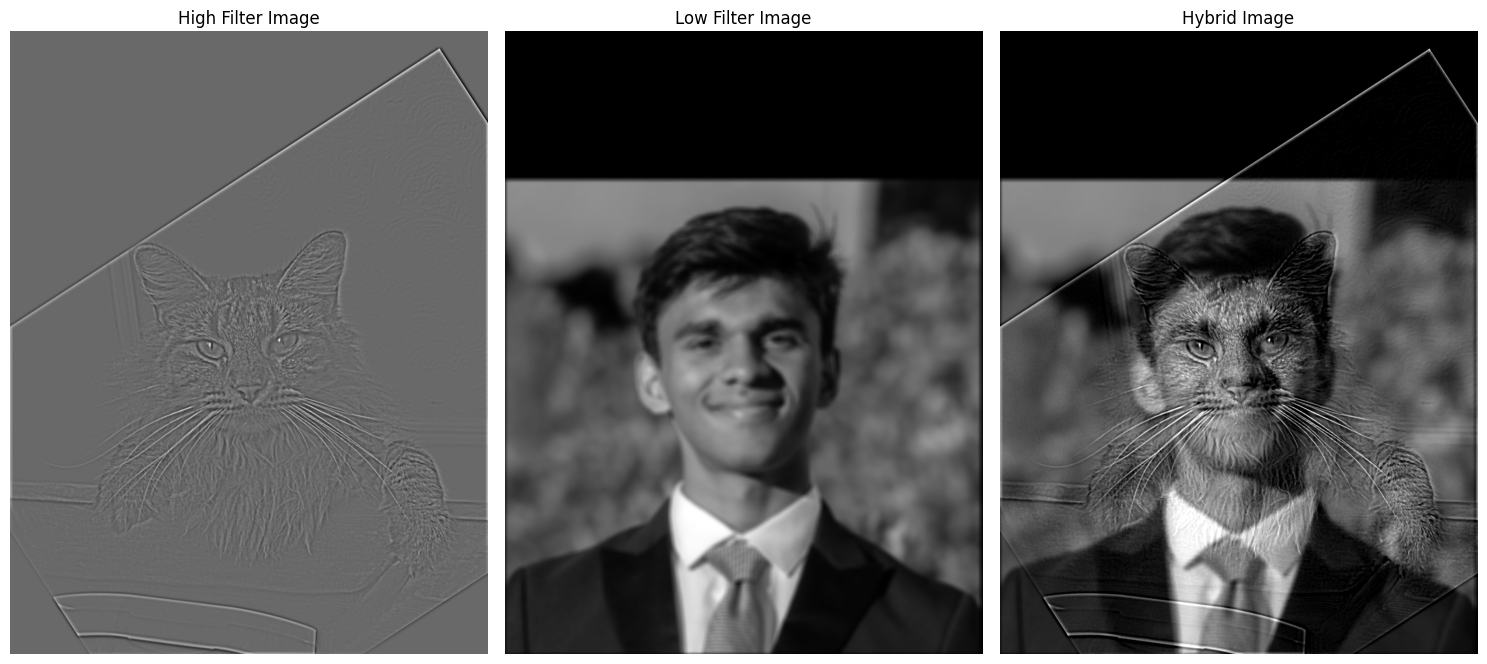

In [36]:
def hybrid_image_gray(im1, im2, sigma1, sigma2):
    im1_gray = rgb2gray(im1)
    im1_blur = blur(im1_gray, sigma=sigma1)
    im1_edges = im1_gray - im1_blur

    im2_gray = rgb2gray(im2)
    im2_blur = blur(im2_gray, sigma=sigma2)
    hybrid = np.clip(im2_blur+500*im1_edges, 0., 255.).astype(int)
    return im1_edges, im2_blur, hybrid

def hybrid_image_color(im1, im2, sigma1, sigma2):
    im1_blur = blur3d(im1, sigma=sigma1)
    im1_edges = im1 - im1_blur
    im2_blur = blur3d(im2, sigma=sigma2)

    hybrid = np.clip(im2_blur+500*im1_edges, 0., 255.).astype(int)
    return im1_edges, im2_blur, hybrid

# im2 = process_img('eaten_papajohn.jpg') 
# im1 = process_img('full_papajohn.jpg')

# im1_gray = process_img_gray('choc_icecream.jpg') 
# im2_gray = process_img_gray('blue_icecream.jpg')

im1 = process_img('nutmeg.jpg') 
im2 = process_img('Yash_Dave.jpg')
im1_aligned, im2_aligned = align_images(im1, im2)
im1_edges, im2_blur, hybrid = hybrid_image_gray(im1_aligned, im2_aligned, 10, 10)
plot_images([im1_edges, im2_blur, hybrid], ["High Filter Image", "Low Filter Image", "Hybrid Image"], vertical=False)